In [1]:
%load_ext autoreload
%autoreload 2

import torch
import numpy as np

torch.set_default_device('cuda')
np.random.seed(1)

import os, sys
m_path = os.path.abspath(os.path.join("..\.."))
if m_path not in sys.path:
    sys.path.append(m_path)

# load data

In [37]:
import pickle
from xcloth.train.data import DataLoader

data_path = "../../data/test_data/"
loader = DataLoader()

loader.load_all(data_path, mask={"1-1"}, excld=False)
loader.stats

{'registered pose': 1,
 'registered mesh': 1,
 'common keys': {'1-1'},
 'extra pose': set(),
 'extra mesh': set()}

In [38]:
t = loader.make_tensors(batch=1)
[print(i.shape) for i in t]

torch.Size([1, 1, 4, 512, 512])
torch.Size([1, 1, 3, 512, 512])
torch.Size([1, 1, 4, 512, 512])
torch.Size([1, 1, 4, 3, 512, 512])
torch.Size([1, 1, 4, 3, 512, 512])


[None, None, None, None, None]

In [39]:
X_train, y_train = loader.make_Xy(*t, depth_offset=.5)
print(X_train.shape, [(i, y.shape) for i, y in y_train.items()])

torch.Size([1, 1, 7, 512, 512]) [('Depth', torch.Size([1, 1, 4, 1, 512, 512])), ('Norm', torch.Size([1, 1, 4, 3, 512, 512])), ('RGB', torch.Size([1, 1, 3, 3, 512, 512]))]


In [40]:
b = 0
X_train = X_train[:, b:1+b]
y_train = {i: y[:, b:1+b] for i, y in y_train.items()}
print(X_train.shape, [(i, y.shape) for i, y in y_train.items()])

torch.Size([1, 1, 7, 512, 512]) [('Depth', torch.Size([1, 1, 4, 1, 512, 512])), ('Norm', torch.Size([1, 1, 4, 3, 512, 512])), ('RGB', torch.Size([1, 1, 3, 3, 512, 512]))]


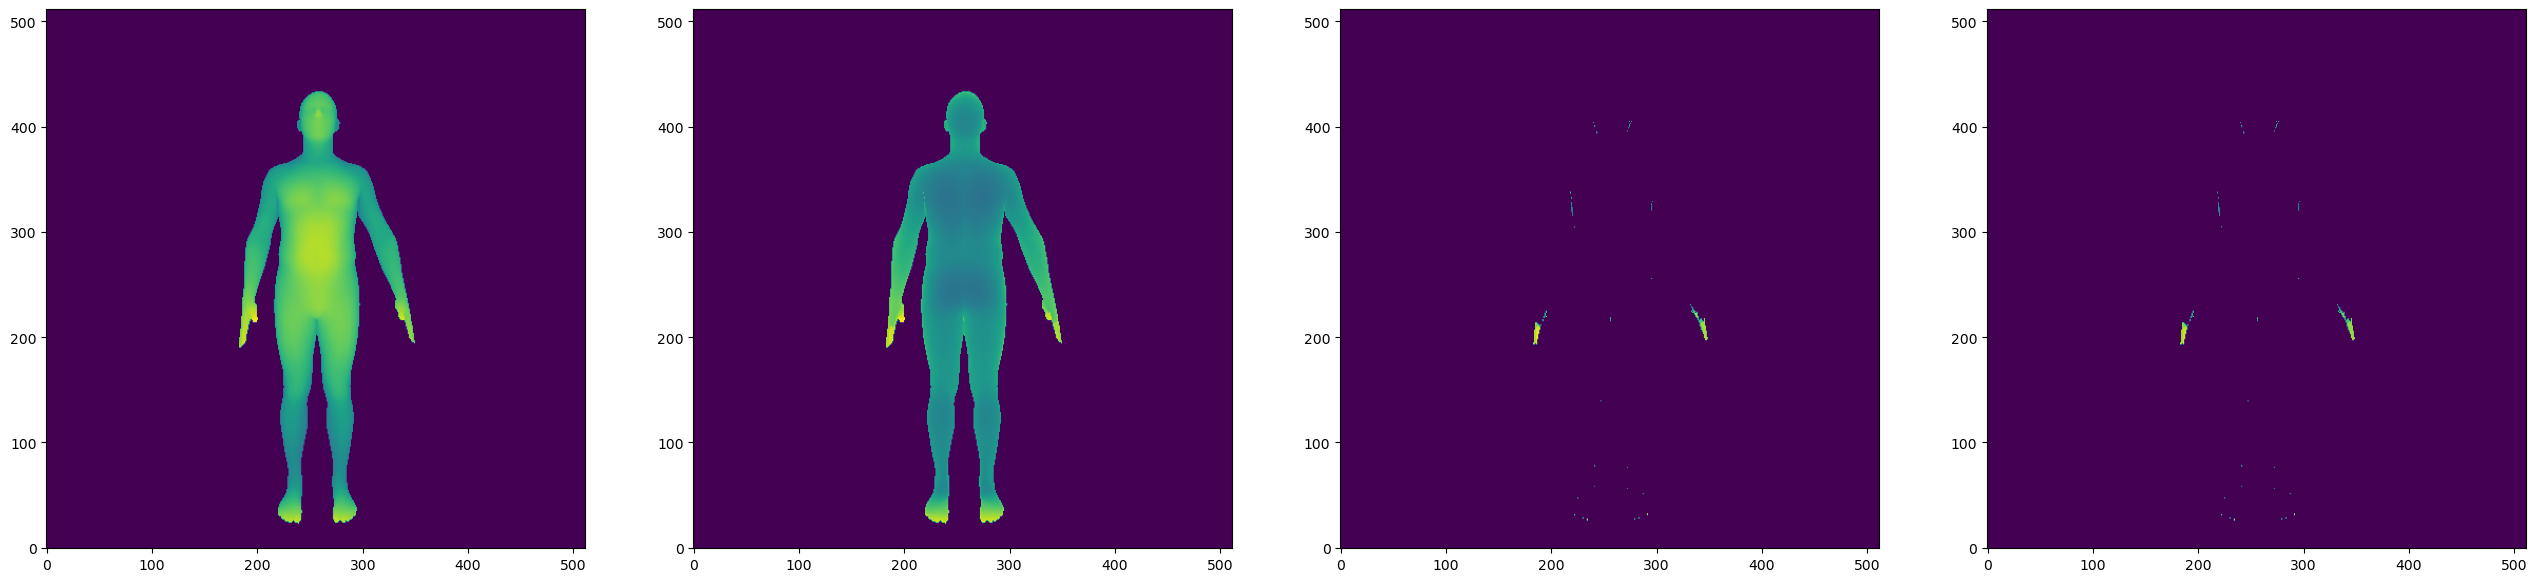

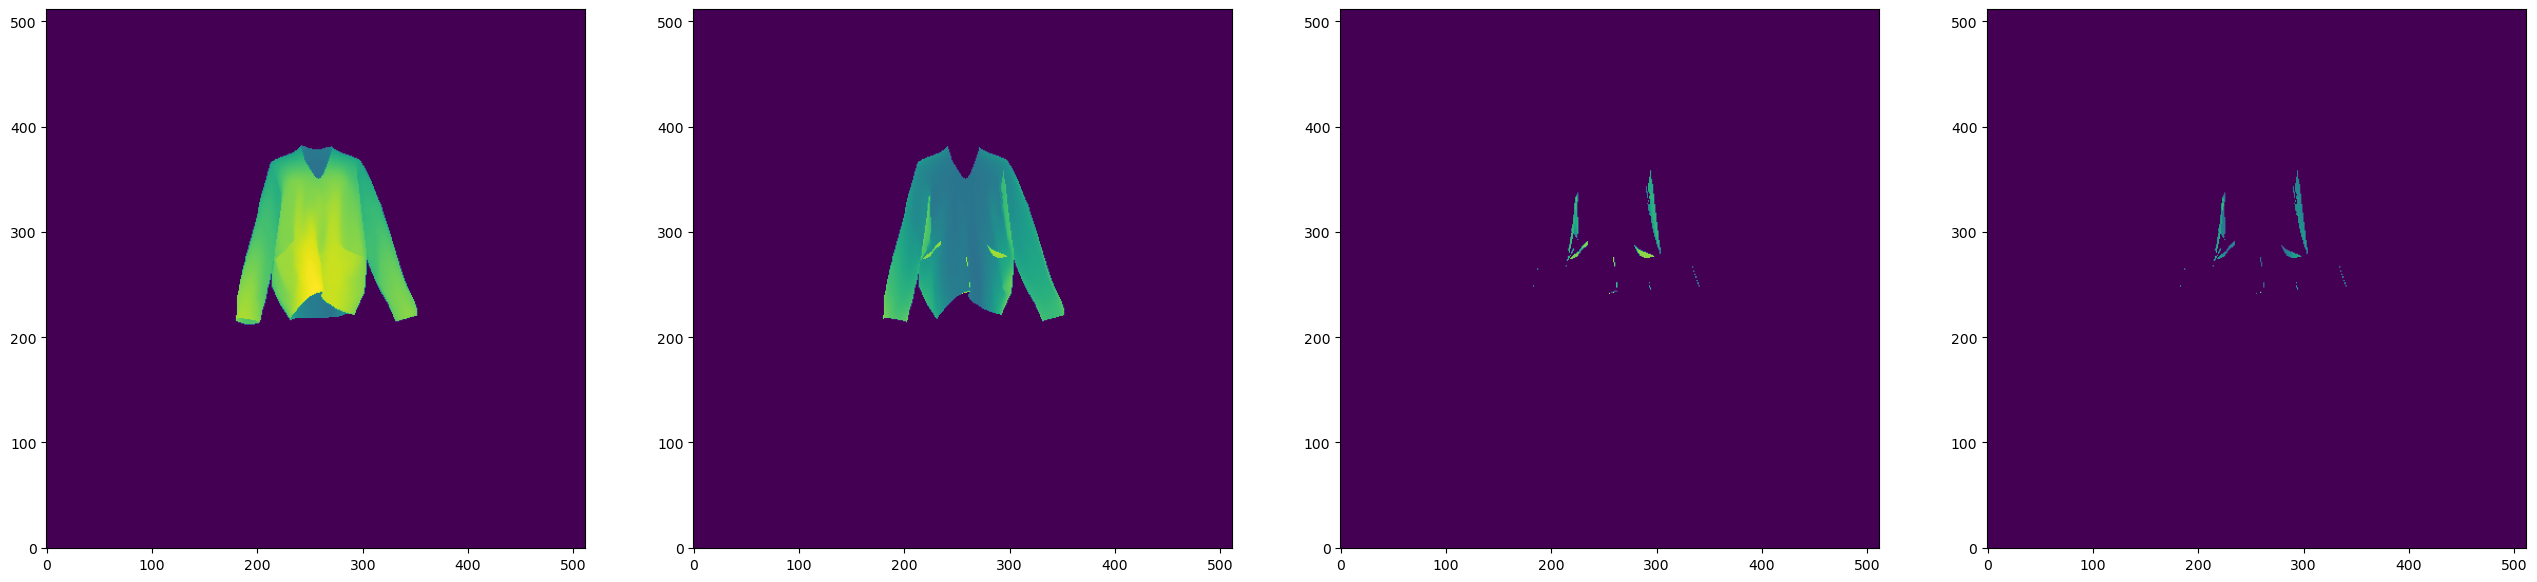

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


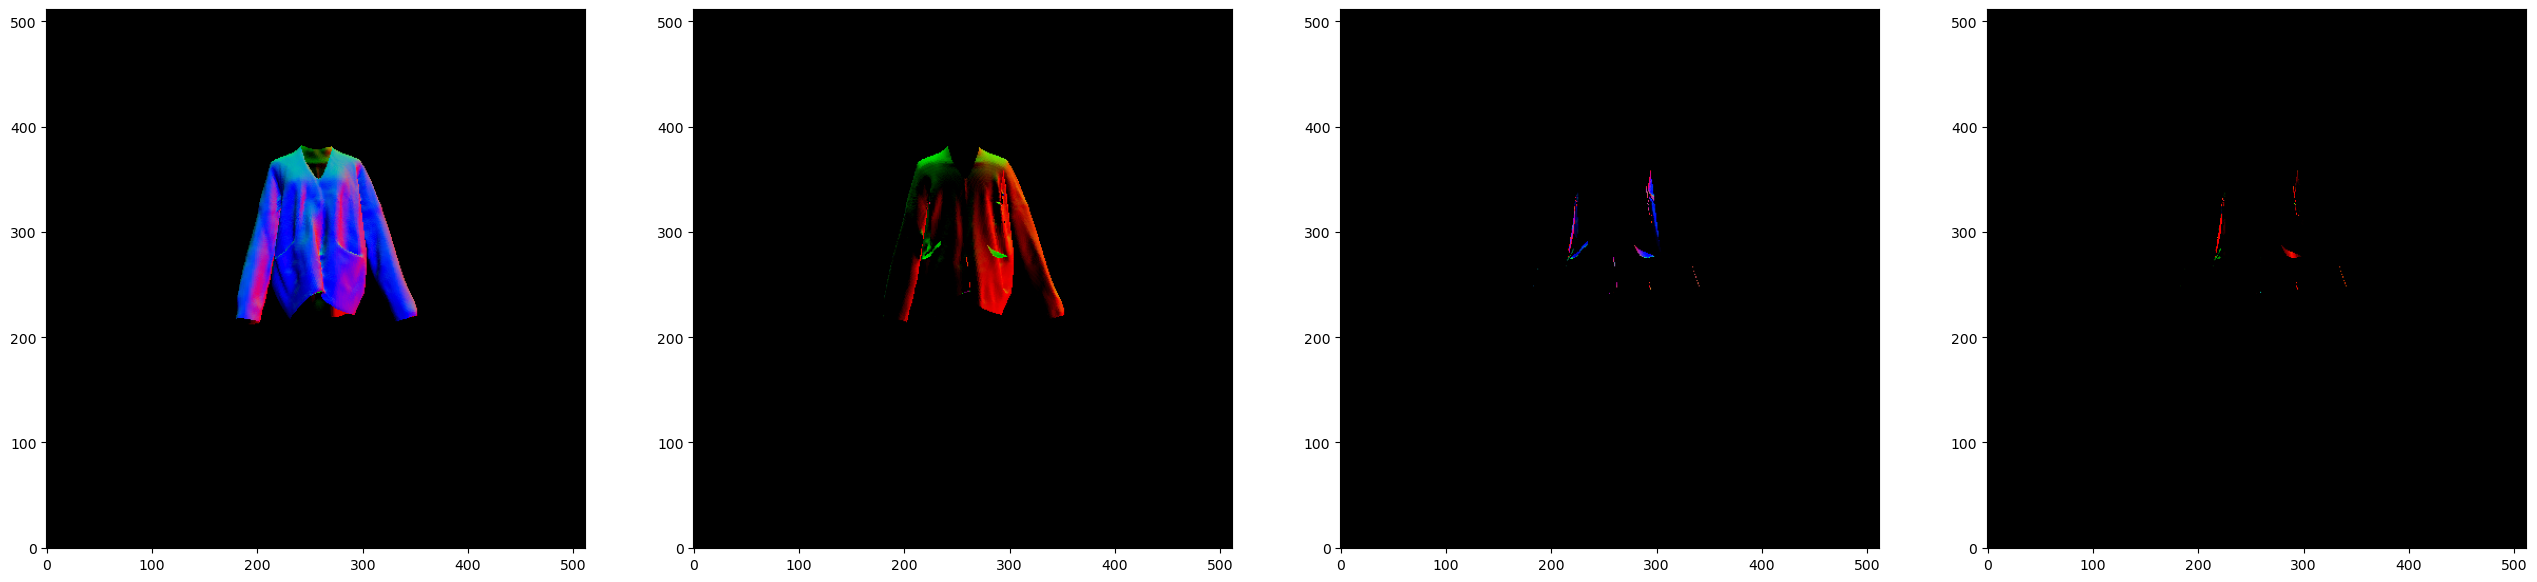

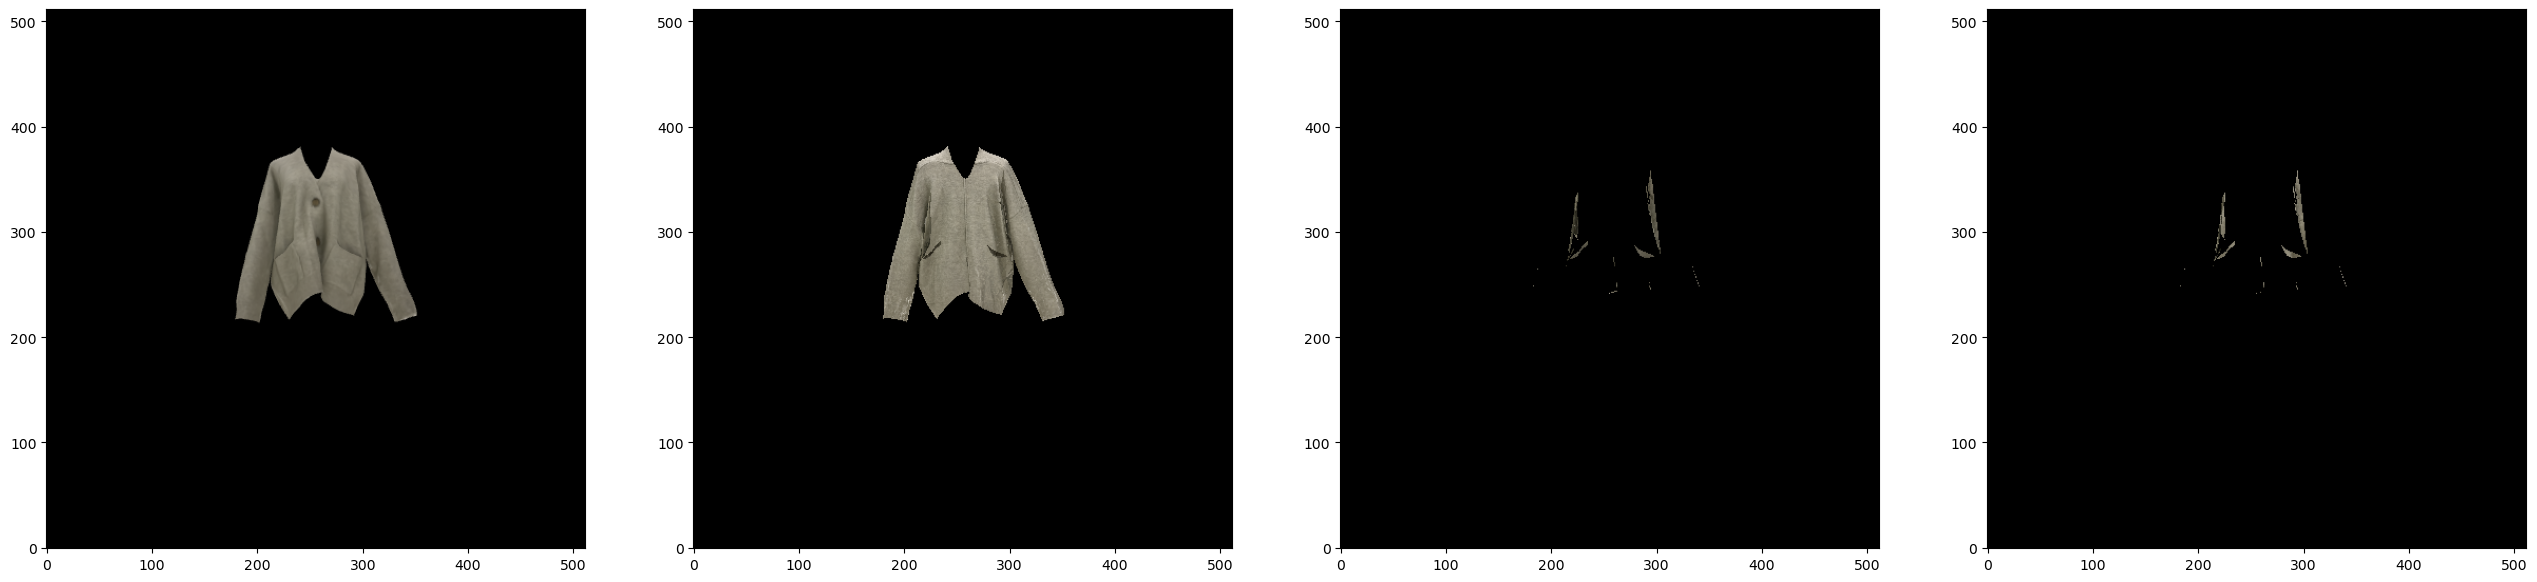

In [41]:
from matplotlib import pyplot as plt
from xcloth.utils import plot_3d, plot_depth

plot_depth(X_train[0, 0, 3:].cpu().numpy())
plot_depth(y_train["Depth"][0, 0].cpu().numpy().squeeze())
plot_3d(y_train["Norm"][0, 0].cpu().numpy())
plot_3d(np.concatenate([X_train[0, 0, :3].unsqueeze(0).cpu().numpy(), y_train["RGB"][0, 0].cpu().numpy()], axis=0))

In [7]:
X_train[0, 0, 3:].cpu().numpy().shape

(4, 512, 512)

In [8]:
from xcloth.components.utils import GarmentModel3D

garment = GarmentModel3D(
    img=X_train[0, 0, :3].cpu().numpy(),
    pm_depth=y_train["Depth"][0, 0].cpu().numpy(),
    pm_norm=y_train["Norm"][0, 0].cpu().numpy(),
    pm_rgb=y_train["RGB"][0, 0].cpu().numpy(),
).make_rgb()

garment.reconstruct(thres=0, depth_offset=.5)
garment.save_pcd("../no_git_test_data/88-1/reconstructed")

In [9]:
from xcloth.train import train_model
from xcloth.production import XCloth

xcloth = XCloth()
# xcloth(sample_in, sample_smpl)

train_model(
    xcloth,
    X_train,
    y_train,
    verbose=True,
    n_epoch=1000,
    reduction="mean",
    weight=[1., 0.1, 1., 0.05, 1, 0.5],
    params_path="../../data/test_data/params.pt",
    separate_bg=True
)

epoch 1: loss: [tensor(2.5640, device='cuda:0', grad_fn=<AddBackward0>)]
epoch 2: loss: [tensor(2.2449, device='cuda:0', grad_fn=<AddBackward0>)]
epoch 3: loss: [tensor(1.9480, device='cuda:0', grad_fn=<AddBackward0>)]
epoch 4: loss: [tensor(1.7191, device='cuda:0', grad_fn=<AddBackward0>)]
epoch 5: loss: [tensor(1.5874, device='cuda:0', grad_fn=<AddBackward0>)]
epoch 6: loss: [tensor(1.5105, device='cuda:0', grad_fn=<AddBackward0>)]
epoch 7: loss: [tensor(1.4655, device='cuda:0', grad_fn=<AddBackward0>)]
epoch 8: loss: [tensor(1.4411, device='cuda:0', grad_fn=<AddBackward0>)]
epoch 9: loss: [tensor(1.4229, device='cuda:0', grad_fn=<AddBackward0>)]
epoch 10: loss: [tensor(1.4061, device='cuda:0', grad_fn=<AddBackward0>)]
epoch 11: loss: [tensor(1.3919, device='cuda:0', grad_fn=<AddBackward0>)]
epoch 12: loss: [tensor(1.3829, device='cuda:0', grad_fn=<AddBackward0>)]
epoch 13: loss: [tensor(1.3785, device='cuda:0', grad_fn=<AddBackward0>)]
epoch 14: loss: [tensor(1.3754, device='cuda:0'

In [42]:
from xcloth.production import XCloth

model = XCloth()
model.load("../../data/test_data/params.pt")

thres = 0.25

with torch.no_grad():
    r = model(X_train[0, 0, :3], X_train[0, 0, 3:])

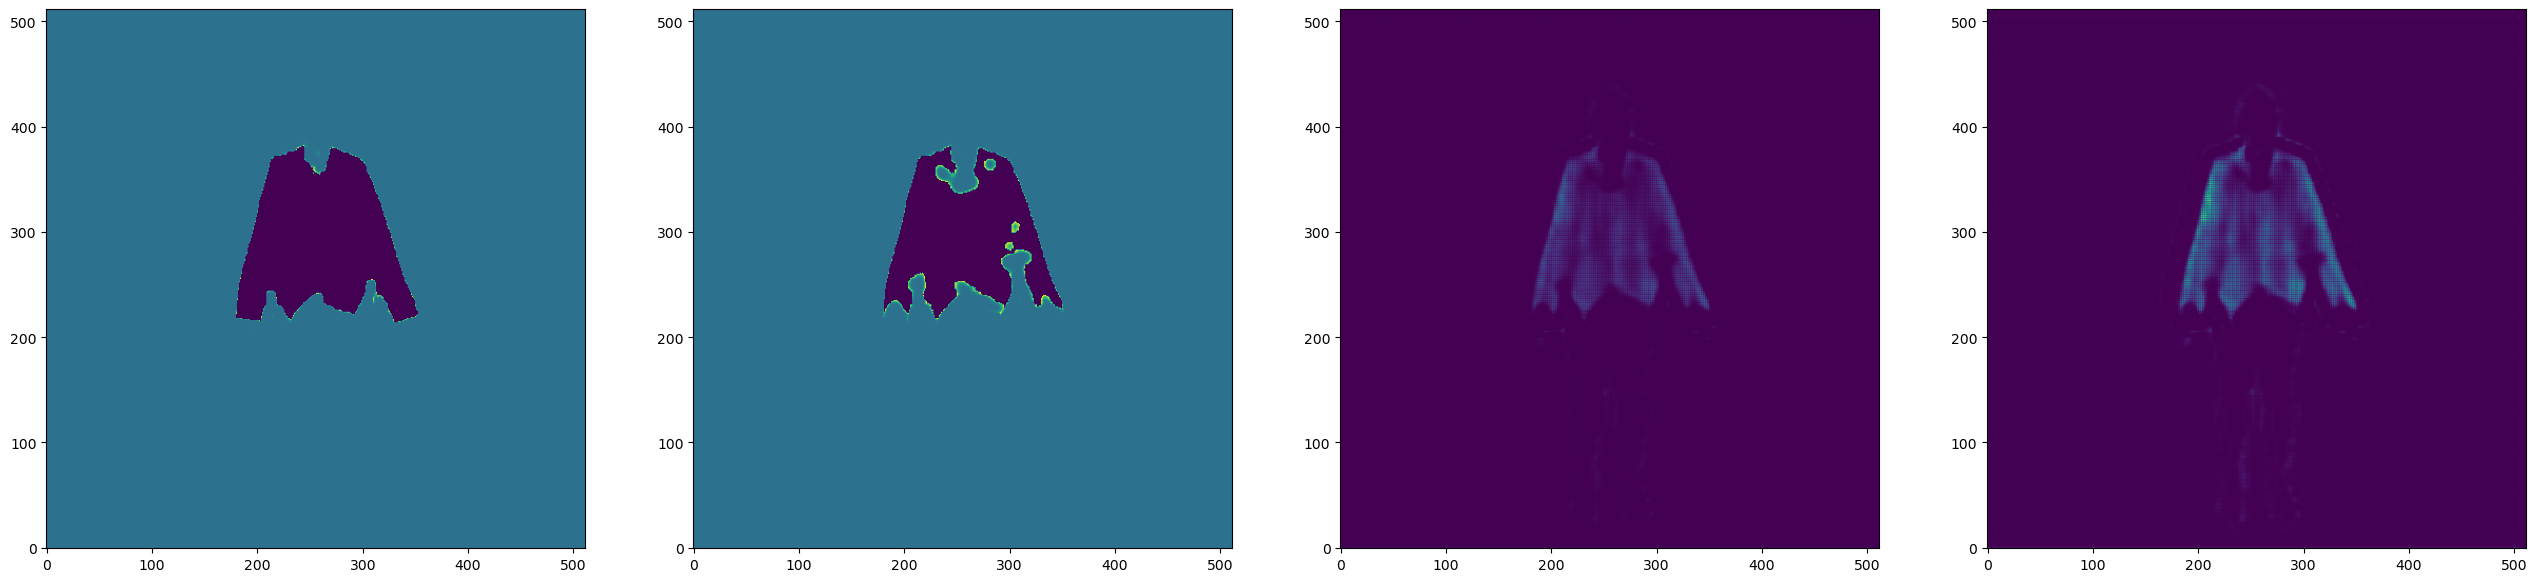

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


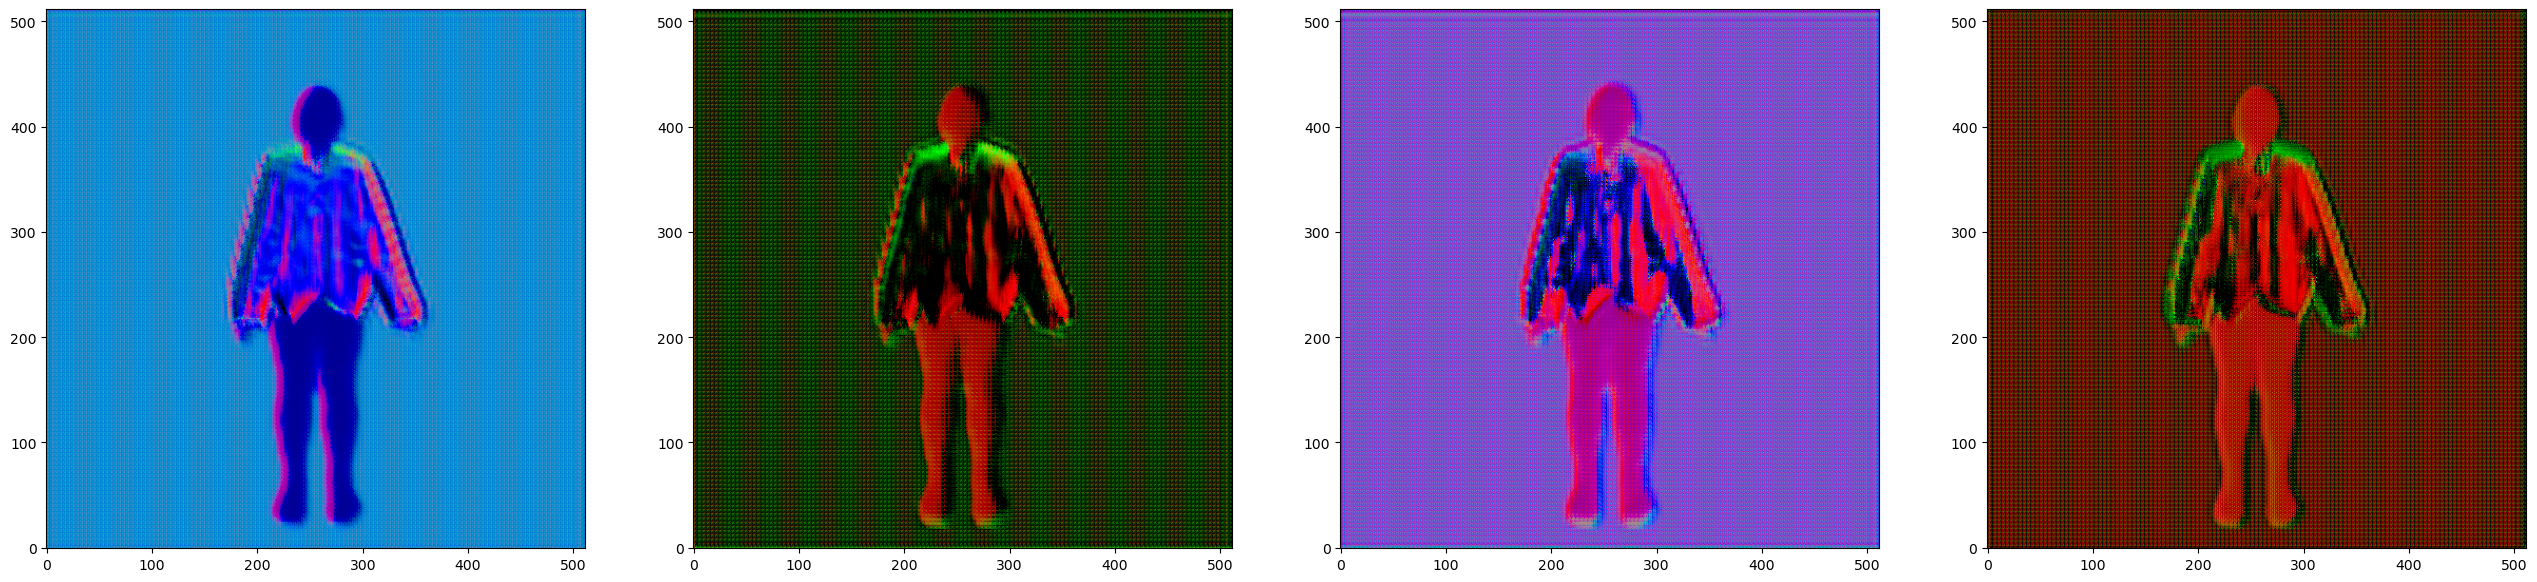

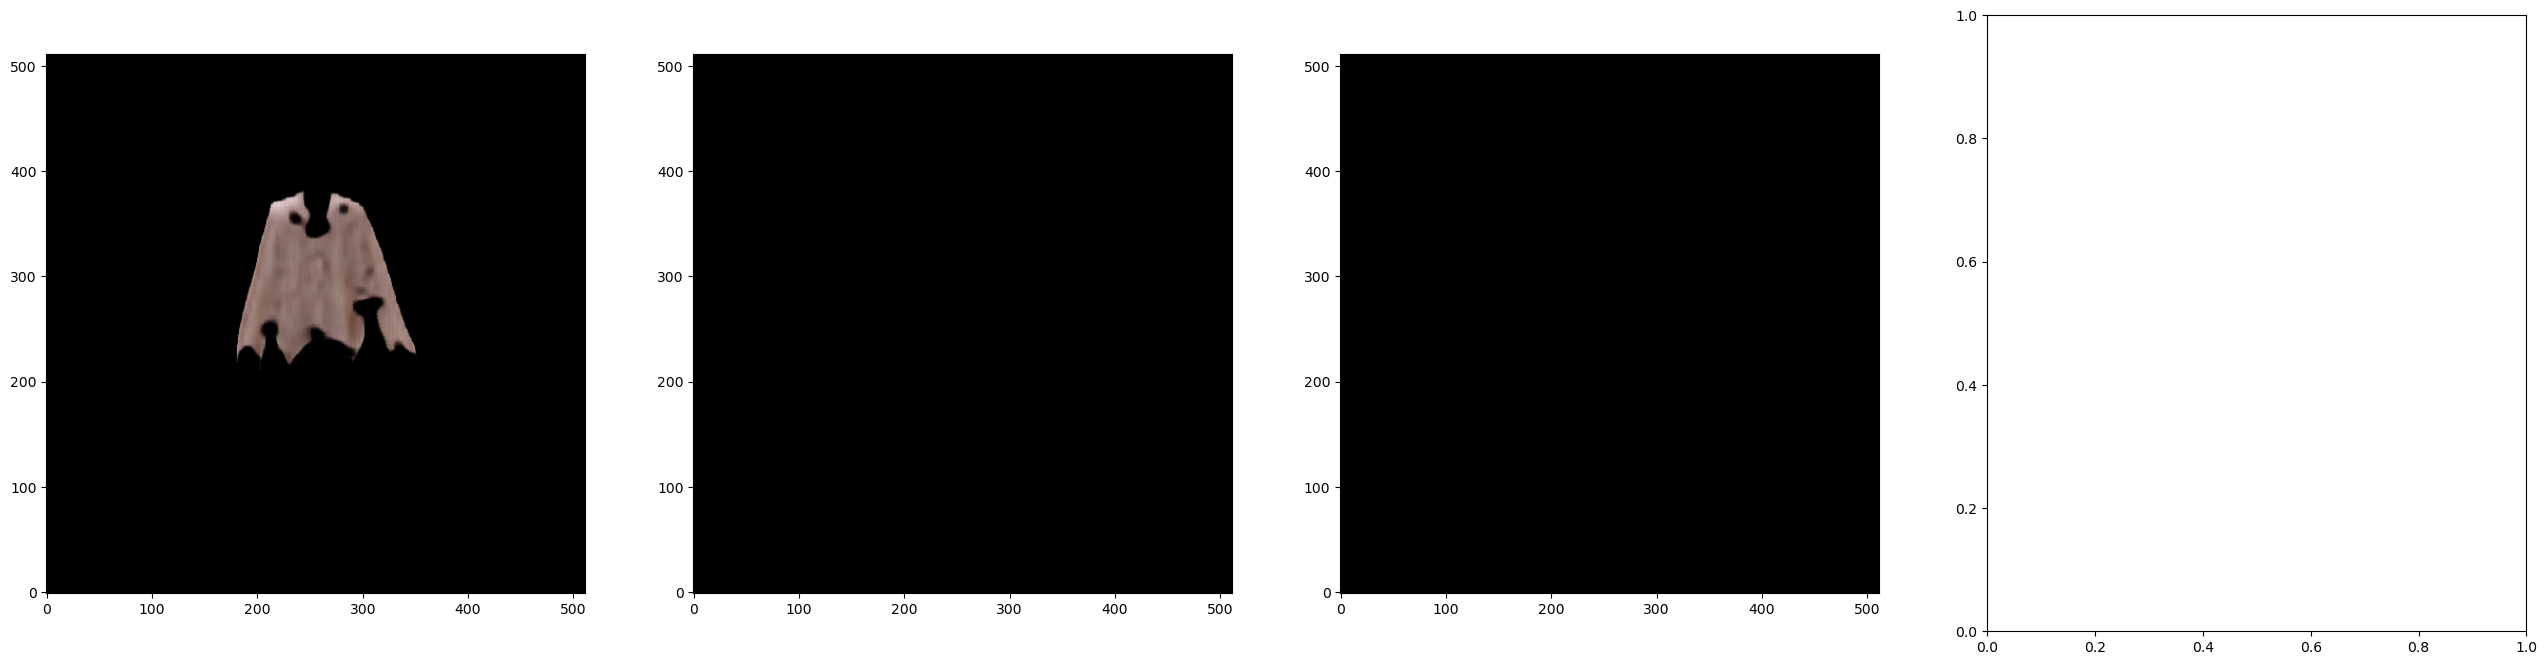

In [43]:
tmp = r["Depth"][0].cpu().detach().numpy().squeeze() - .5
tmp[np.abs(tmp) < thres] = 0
plot_depth(tmp)
plot_3d((r["Norm"][0].cpu().detach().numpy()))
plot_3d((r["RGB"][0].cpu().detach().numpy()))

In [44]:
from xcloth.components.utils import GarmentModel3D
mesh = GarmentModel3D.from_tensor_dict(r, 1)

In [45]:
# mesh[0].mask = y_train["Depth"][0, 0, 0].squeeze().cpu().numpy()
# mesh[0].mask = mesh[0].mask != 0
mesh[0].reconstruct(thres=thres, depth_offset=.5, path="C:\\Users\\User\\CODE\\FYP\\models\\xcloth\\no_git_test_data\\pcd\\88-1_r")

In [46]:
%reload_ext autoreload
%autoreload 2

mesh[0].to_obj(path="C:\\Users\\User\\CODE\\FYP\\models\\xcloth\\no_git_test_data\\pcd\\88-1_r\\reconstructed.obj", mode="poisson", depth=7)

TriangleMesh with 49733 points and 99206 triangles.